In [ ]:
!conda install scikit-image

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage import io
from scipy.optimize import minimize_scalar
%matplotlib inline

In [8]:
def apply_coeff(img, coeff, border=False):
    tmp = img.astype("float")
    if border:
        for i in range(img.shape[0]):
            tmp[i] += coeff[i]
    else :
        tmp += coeff
    return tmp
    
def lin_interpolation_coeff(img1, img2, coeff1, coeff2) :
    assert img1.shape[0] == img2.shape[0]
    coeff = np.zeros((img1.shape[0], img1.shape[1] + img2.shape[1]))
    for i in range(coeff.shape[0]):
        for j in range(coeff.shape[1]):
            coeff[i, j] = coeff1[i] + j * (coeff2[i] - coeff1[i]) / (coeff.shape[1] - 1)
    return coeff

def reduce_geom_noise(img, blocks_num=20):
    blocks = []
    steps = np.linspace(0, img.shape[1], blocks_num + 1).astype("uint64")
    for i in range(blocks_num):
        blocks.append(img[:, steps[i]:steps[i + 1]])
    width = 0
    for i in range(blocks_num):
        width += blocks[i].shape[1]
    assert width == img.shape[1]
    
    coeffs = []
    for i in range(blocks_num):
        coeffs.append(coeff_reduce_geom_noise(blocks[i]))
    coeffs = np.array(coeffs)
        
    new_blocks = []
    left_block = blocks[0][:, :blocks[0].shape[1] / 2]
#     left_coeff = coeff_reduce_geom_noise(left_block)
    new_blocks.append(apply_coeff(left_block, coeffs[0], border=True))
    for i in range(blocks_num - 1):
        cur_left = blocks[i][:, -blocks[i].shape[1] / 2:]
        cur_right = blocks[i + 1][:, :blocks[i + 1].shape[1] / 2]
        cur_coeffs = lin_interpolation_coeff(cur_left, cur_right, coeffs[i], coeffs[i + 1])
        cur_img = np.concatenate([cur_left, cur_right], axis=1)
        new_blocks.append(apply_coeff(cur_img, cur_coeffs))
    right_block = blocks[-1][:, -blocks[0].shape[1] / 2:]
    right_coeff = coeff_reduce_geom_noise(right_block)
    new_blocks.append(apply_coeff(right_block, right_coeff, border=True))
    return np.concatenate(new_blocks, axis=1)
    

def coeff_reduce_geom_noise(img):
    img = img.astype("float")
    alpha = np.zeros(img.shape[0])
    for i in range(1, img.shape[0]):
        alpha[i] = np.median(img[i - 1] - img[i])
    
    coeff = alpha - np.sum(alpha) / img.shape[0]
    for i in range(1, img.shape[0]):
        coeff[i] = coeff[i] + coeff[i - 1]
    
    return coeff

def imshow(img):
    tmp = img.copy()
    for i in range(tmp.shape[0]):
        for j in range(tmp.shape[1]):
            if tmp[i, j] > 255:
                tmp[i, j] = 255
            elif tmp[i, j] < 0:
                tmp[i, j] = 0
    io.imshow(tmp.astype("uint8"))
    

In [6]:
img = io.imread("1272.tif")
img.shape

(288, 7999)

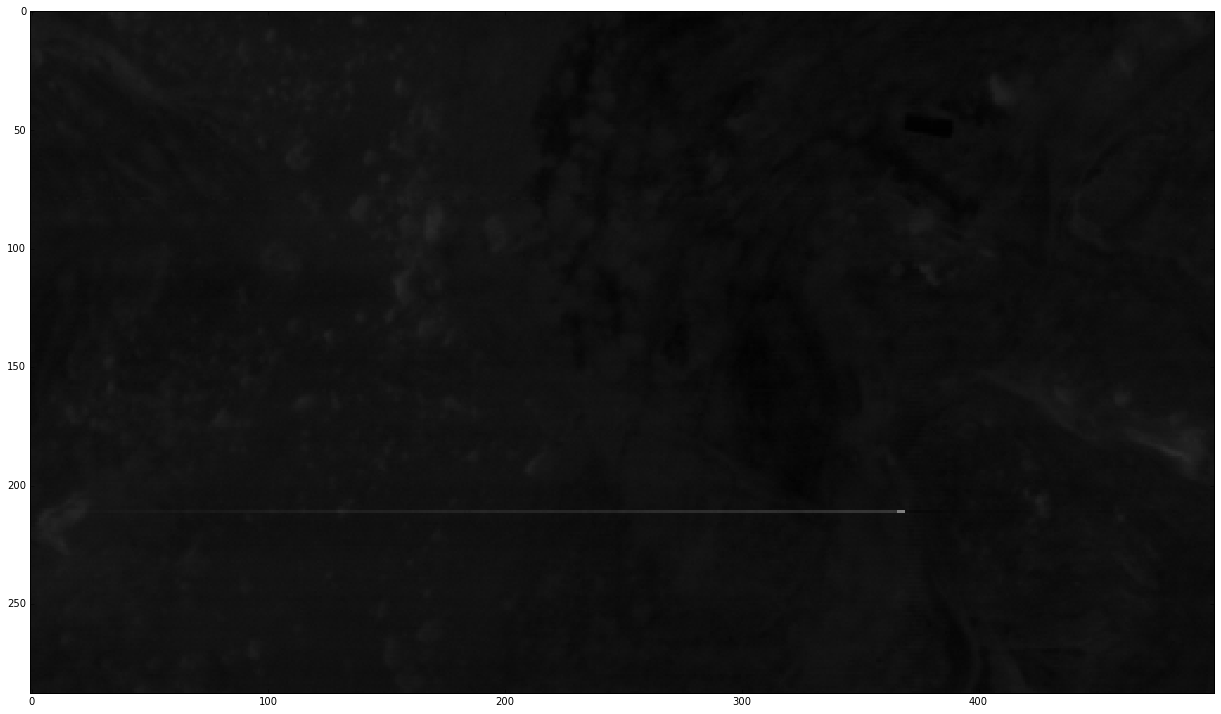

In [9]:
plt.figure(figsize=(20, 10))
imshow(reduce_geom_noise(img)[:, 7000:7500])